In [1]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import os
!pip install torchinfo
from torchinfo import summary
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from sklearn.metrics import recall_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18
import uuid
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output
!pip install git+https://github.com/openai/CLIP.git
from albumentations.core.composition import Compose, OneOf
from albumentations.pytorch import ToTensorV2
import albumentations as A    
    
import clip
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"


import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning import Callback
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import wandb
 

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-eg794bhe
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-eg794bhe
  Resolved https://github.com/openai/CLIP.git to commit d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 598.6 kB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=023fed292062249f9495ac30d59b1d057aff001b299df8fb5f5058845f380f2d
  Stored in directory: /tmp/pip-ephem-wheel-cache-30oujkvo/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


## Настрока блокнота

In [2]:
class CFG:
    batch_size=64
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_epochs = 10
    wandb_project = "construction_equipment"
    wandb_entity = "vladsmirn_"
    img_size = 224
    n_fold = 5
    k_fold = 3
    
    lr = 0.00012
    lr_schedule = "LambdaLR"
    parametr_lambda = 0.65 
    
    id_notebook=str(uuid.uuid4())
    
print("id_notebook: " + CFG.id_notebook)
 

id_notebook: 2fc22ce3-b2dc-41e2-9d59-4991e9183ca0


In [3]:
def get_transform(phase: str, img_size: int):
    if phase == 'train':
        return Compose([
#             A.Resize(height=img_size, width=img_size),
            A.RandomResizedCrop(height=img_size, width=img_size, scale=(0.97, 1.0)),
            A.Flip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(p=0.1),
            A.OneOf([
                A.RandomBrightnessContrast(p=0.2),
                A.RandomGamma(p=0.2),
            ], p=0.5),
            A.OneOf([
                A.Blur(p=0.1),
                A.GaussianBlur(p=0.1),
                A.MotionBlur(p=0.1),
            ], p=0.1),
            A.OneOf([
                A.GaussNoise(p=0.1),
                A.ISONoise(p=0.1),
            ], p=0.2),
            A.Normalize(),
            ToTensorV2(),
        ])
    else:
        return Compose([
            A.Resize(height=img_size, width=img_size),
            A.Normalize(),
            ToTensorV2(),
        ])

In [4]:
DIR_TRAIN = "../input/construction-equipment/train/"
DIR_TEST = "../input/construction-equipment-test/test/"

PATH_TRAIN = "../input/construction-equipment/train.csv"
PATH_TEST = "../input/construction-equipment-test/test.csv"

def KFOLD(df, n_fold=5 , k_fold=1, seed=43, column_x='path', column_y='class'):
    skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
    
    for i_fold , (train_idx, valid_idx) in enumerate(skf.split(df[column_x], df[column_y])):
        if(i_fold+1 == k_fold):
            df_train = df.iloc[train_idx]
            df_valid = df.iloc[valid_idx]
            break

    print(f"train size: {len(df_train)}")
    print(f"valid size: {len(df_valid)}")
    
    return df_train, df_valid

class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        image_path, label = self.data_df.iloc[idx]['path'], self.data_df.iloc[idx]['class']
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image=image)['image'] 
#         image = image.permute(0,1,2) 
#         image = Image.fromarray(image)
#         image = preprocess(image).to(device)  
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)
    
 
 

data_df = pd.read_csv(PATH_TRAIN)
data_df["path"] = data_df["ID_img"].apply(lambda image_name : f'{DIR_TRAIN}{image_name}')
train_df, valid_df = KFOLD(data_df, n_fold=CFG.n_fold, k_fold=CFG.k_fold)
train_dataset = ImageDataset(train_df, get_transform("train",CFG.img_size))
valid_dataset = ImageDataset(valid_df, get_transform("valid",CFG.img_size))
 

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=CFG.batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=CFG.batch_size)
                                            
# CFG.steps_per_epoch = len(train_loader)
CFG.steps_per_epoch = len(train_loader) 
images, labels =  next(iter(train_loader))
# model_clip.encode_image(images[:1])
images.shape

train size: 3992
valid size: 998


torch.Size([64, 3, 224, 224])

In [5]:

'''
https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling/notebook
 
CFG.lr_schedule = "OneCycleLR"
CFG.num_epochs = 10
CFG.steps_per_epoch = 62
CFG.max_lr = 0.0002

CFG.lr_schedule = "CyclicLR_exp_range" 
CFG.base_lr = 0.0001 
CFG.max_lr = 0.0002 
CFG.step_size_up = 100
CFG.gamma = 0.992

'''

 
def choose_configure_optimizers(CFG,model = torch.nn.Linear(2, 1),show=False):
    
  
    CFG.optimizer = "Adam"
    if not hasattr(CFG, 'lr'):
        CFG.lr = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)    

         
    if not hasattr(CFG, 'lr_schedule'):
        return optimizer
    
 
    if CFG.lr_schedule == "OneCycleLR" :
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                        epochs=CFG.num_epochs, 
                                                        steps_per_epoch= CFG.steps_per_epoch,
                                                        max_lr=CFG.max_lr)
        scheduler = {'scheduler': scheduler, 'interval': 'step'}
        number_steps_scheduler = CFG.steps_per_epoch * CFG.num_epochs # for show
        
        
    if CFG.lr_schedule == "CyclicLR_exp_range" :
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                      base_lr=CFG.base_lr, 
                                                      max_lr=CFG.max_lr, 
                                                      step_size_up=CFG.step_size_up,
                                                      mode="exp_range",
                                                      gamma=CFG.gamma,
                                                      cycle_momentum=False)
        scheduler = {'scheduler': scheduler, 'interval': 'step'}
        number_steps_scheduler = CFG.steps_per_epoch * CFG.num_epochs
        
    if CFG.lr_schedule == "LambdaLR" :
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, 
                                                      lr_lambda = lambda epoch: CFG.parametr_lambda ** epoch)
        
        scheduler = {'scheduler': scheduler, 'interval': 'epoch'}
        number_steps_scheduler = CFG.num_epochs
        
      
        
    if show : 
        lrs = []
        for i in range(number_steps_scheduler):
            optimizer.step()
            lrs.append(optimizer.param_groups[0]["lr"])
            scheduler['scheduler'].step()
            
        plt.title(CFG.lr_schedule)  
        plt.plot(lrs)  
        plt.xlabel("step") 
        plt.ylabel("lr")
        plt.show()
        print("last lr:"+str(lrs[-1]))
        print(optimizer)

    return optimizer, scheduler

 

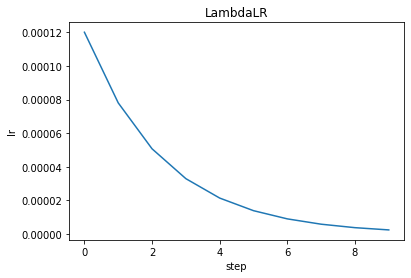

last lr:2.4854295405468758e-06
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.00012
    lr: 1.6155292013554694e-06
    maximize: False
    weight_decay: 0
)


In [6]:
# DEGUG
_ = choose_configure_optimizers(CFG,show=True) 

##   Объявление модели


In [7]:
model_clf = models.convnext.convnext_small(pretrained=True)
model_clf.classifier[2] = nn.Linear(768, 8) 

model_clf.to(CFG.device)

 
summary(model_clf)

Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth


  0%|          | 0.00/192M [00:00<?, ?B/s]

Layer (type:depth-idx)                        Param #
ConvNeXt                                      --
├─Sequential: 1-1                             --
│    └─ConvNormActivation: 2-1                --
│    │    └─Conv2d: 3-1                       4,704
│    │    └─LayerNorm2d: 3-2                  192
│    └─Sequential: 2-2                        --
│    │    └─CNBlock: 3-3                      79,296
│    │    └─CNBlock: 3-4                      79,296
│    │    └─CNBlock: 3-5                      79,296
│    └─Sequential: 2-3                        --
│    │    └─LayerNorm2d: 3-6                  192
│    │    └─Conv2d: 3-7                       73,920
│    └─Sequential: 2-4                        --
│    │    └─CNBlock: 3-8                      306,048
│    │    └─CNBlock: 3-9                      306,048
│    │    └─CNBlock: 3-10                     306,048
│    └─Sequential: 2-5                        --
│    │    └─LayerNorm2d: 3-11                 384
│    │    └─Conv2d: 3-12   

In [8]:
def compute_recall_score(imgs,labels,model):
    model.eval()
    imgs = imgs.to(CFG.device)
    pred = model(imgs)

    pred_numpy = pred.cpu().detach().numpy()
    valid_predicts=[]
    for class_obj in pred_numpy:
          index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
          valid_predicts.append(index)

    return recall_score(labels.cpu().detach().numpy(), valid_predicts, average = "macro")


class LightNPairModel(pl.LightningModule):
    def __init__(self, model,  lr=0.0001):
        super(LightNPairModel, self).__init__()
        self.model = model
        self.criterion = torch.nn.CrossEntropyLoss()
        self.lr = lr

    def forward(self, x, label=False, *args, **kwargs):
        return self.model(x[0])

    def configure_optimizers(self):
        optimizer, scheduler = choose_configure_optimizers(CFG,self.model)
        self.optimizer = optimizer
        return [self.optimizer],[scheduler]

    
    def training_step(self, batch, batch_idx):
        images = batch[0]
        labels = batch[1]
        embedding = self.model(images)
        loss = self.criterion(embedding, labels)
        self.log('train_loss', loss)
        self.log('lr', self.optimizer.param_groups[0]['lr'])
        return loss
    
    def validation_step(self, batch, batch_idx):
        images = batch[0]
        labels = batch[1]
        embedding = self.model(images)
        loss = self.criterion(embedding, labels)
        score = compute_recall_score(images,labels,self.model)
        self.log('valid_loss', loss)    
        self.log('valid_score', score)   
        return loss
    
#     def validation_epoch_end(self, validation_step_outputs):
        
# #         image_array = image_map(self.path_images,self.model,show=False, save=False) 
# #         self.logger.experiment.log({"image": [wandb.Image(image_array)]})
#         self.log('valid_score',  compute_recall_score(valid_loader,model_clf))    
        
lit_model = LightNPairModel(model_clf, lr = CFG.lr)

In [9]:
def run_wandb(wandb_api_key, cfg):
    wandb.require(experiment="service")
    wandb.login(key=wandb_api_key)
    _cfg = cfg() 
    cfg_wandb = dict((name, getattr(_cfg, name)) for name in dir(_cfg) if not name.startswith('__'))
    
    if hasattr(cfg, 'wandb_resume_id') and cfg.wandb_resume_id :
        run = wandb.init(project=cfg.wandb_project, 
                   entity=cfg.wandb_entity, 
                   id=cfg.wandb_resume_id, 
                   resume="allow", 
                   config=cfg_wandb)
    else: 
        run = wandb.init(project=cfg.wandb_project, 
                   entity=cfg.wandb_entity, 
                   settings=wandb.Settings(start_method="fork"), 
                   config=cfg_wandb,
                   resume="allow",
                   id=wandb.util.generate_id())
        
    model_logger = WandbLogger(project=cfg.wandb_project, log_model='all')
    
    return model_logger,run

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
model_logger, _ = run_wandb(user_secrets.get_secret("WANDB_API_KEY"), CFG)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vladsmirn (vladsmirn_). Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/loggers/wandb.py:353: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"


In [10]:
checkpoint_callback = ModelCheckpoint(monitor='valid_score',
#                                       save_top_k=1,
                                      save_weights_only=True,
                                      verbose=False,
                                      mode='max')

if torch.cuda.is_available() : 
    trainer = Trainer(
        max_epochs=CFG.num_epochs,
        gpus=[0],
        callbacks=[checkpoint_callback], 
        logger=model_logger,
        log_every_n_steps = 1 
    )
else :
    trainer = Trainer(
        max_epochs=CFG.num_epochs,
        callbacks=[checkpoint_callback], 
        logger=model_logger,
        log_every_n_steps = 1 
    )

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"


In [11]:
trainer.fit(lit_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)
 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Предсказание 

In [12]:
# _, run = run_wandb(user_secrets.get_secret("WANDB_API_KEY"), CFG)
# model_clf_best = classification_construction(model_clip)
# artifact = run.use_artifact('vladsmirn_/construction_equipment/model-3qeaibwz:v14', type='model')
# artifact_dir = artifact.download()
# checkpoint =   os.path.join(artifact_dir, "model.ckpt" )

# from collections import OrderedDict
# state_dict = torch.load(checkpoint,map_location ='cpu')['state_dict']
# new_state_dict = OrderedDict()
# for k, v in state_dict.items():
#     name = k[6:]  
#     new_state_dict[name] = v

# model_clf_best.load_state_dict(new_state_dict)

 

In [13]:
test_df = pd.read_csv(PATH_TEST)
test_df["path"] = test_df["ID_img"].apply(lambda image_name : f'{DIR_TEST}{image_name}')
test_df = test_df.drop(["class"], axis = 1)

class TestImageDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        image_path = self.data_df.iloc[idx]['path']
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image=image)['image'] 
 
        
        return image
    
    def __len__(self):
        return len(self.data_df)
    
test_dataset = TestImageDataset(test_df,get_transform("valid",CFG.img_size))

In [14]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=32,
                                            )

In [15]:
torch.save(model_clf, "./model_clf.pt")

model_clf.eval()
predicts = []
model_clf.to(CFG.device)
for imgs in tqdm(test_loader):
    
    imgs = imgs.to(CFG.device)
    pred = model_clf(imgs)
    for class_obj in pred:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      predicts.append(index)

100%|██████████| 67/67 [00:26<00:00,  2.49it/s]


In [16]:
test_df["class"] = predicts
test_df = test_df.drop(["path"], axis = 1)
test_df.head()

test_df.to_csv("submit.csv", index=False)